In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# enter the last 5 characters of the token before proceeding
token='313b70b9bc70f71e37bf245e4cb5fed61995ace81ae6c2a47a2d521ed4c532ad5f1c012f20a0b4eed530dd2d202be15c482af7b31704b06fe799e9f3504'

## Bernstein-Vazirani Demo

### 1. Build and Compile the Circuit

<img src='./bv_circuit.png' width=50%>

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
q = QuantumRegister(4, 'q')
tmp = QuantumRegister(1, 'tmp')
res = ClassicalRegister(4, 'res')

In [3]:
# Build oracle. The secret number is represented by integer s.
s = 13 # 1101
oracle = QuantumCircuit(q, tmp, res)
for i in range(len(q)):
    if (s & (1 << i)):
        oracle.cx(q[i], tmp[0])

In [4]:
# Embed oracle in the larger BV circuit
bv = QuantumCircuit(q, tmp, res)
bv.x(tmp[0])
bv.barrier()
bv.h(q)
bv.h(tmp)
bv.barrier()
bv += oracle
bv.barrier()
bv.h(q)
bv.h(tmp)
bv.barrier()
bv.measure(q, res)

In [5]:
%matplotlib inline
bv.draw()

### 2. Execute on a Simulator

In [6]:
# Access local simulators from Qiskit Aer
from qiskit import Aer, execute
Aer.backends()

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

In [7]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(bv, simulator).result()

In [8]:
from qiskit.tools.visualization import plot_histogram
sim_counts = sim_result.get_counts()
sim_counts

{'1101': 1024}

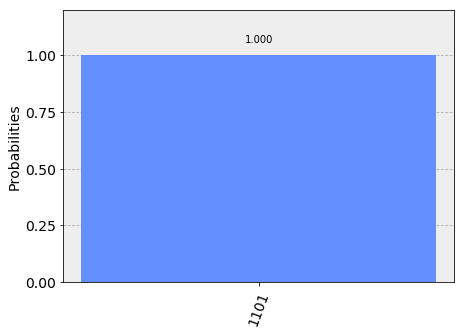

In [9]:
plot_histogram(sim_counts)

The Bernstein-Vazirani circuit finds the secret bitstring 100% of the time, with just 1 Oracle query.

### 3. Execute on a Quantum Computer

In [10]:
# authenticate to use IBMQ remote backends 
from qiskit import IBMQ
IBMQ.enable_account(token)
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [11]:
# let's choose a 5-qubit device and execute
device = IBMQ.get_backend('ibmq_5_tenerife')

In [12]:
# import jupyter magic tools to ease tracking of submitted job's progress
from qiskit.tools.jupyter import *

In [16]:
%%qiskit_job_status

# qiskit jobs are submitted asynchronously. You can monitor a submitted job's status
job = execute(bv, device, shots=1024, seed_mapper=3)

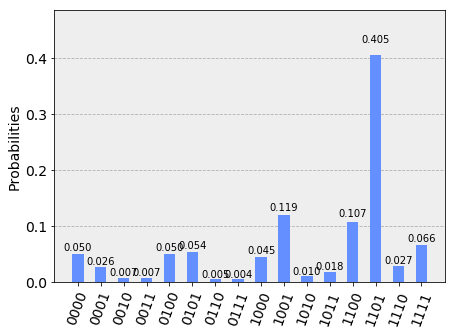

In [17]:
# NOTICE! Executing this cell will block until result is available
device_result = job.result()
device_counts = device_result.get_counts()
plot_histogram(device_counts)

Real devices are noisy. We repeat the experiment for 1000 shots to find the correct answer among the noise.

### 4. Effect of Compilation on Solution

What are the device constraints that must be respected?

In [20]:
from qiskit.mapper import *
coupling_map = CouplingMap(device.configuration().coupling_map)
print(coupling_map)

[[1, 0], [2, 0], [2, 1], [3, 2], [3, 4], [4, 2]]


In [21]:
basis = device.configuration().basis_gates
print(basis)

['u1', 'u2', 'u3', 'cx', 'id']


Our circuit does not conform to the topology of our device as-is. Therefore, the compiler must rewrite the circuit to satisfy the device's connectivity constraints:

<img src='./ibmqx4-connections_1pt2pt0.png' width=20%>

As you will see here, the optimality of the compiler can have a large impact on result fidelity.

{'u3': 1, 'barrier': 4, 'u2': 18, 'cx': 6, 'measure': 4}


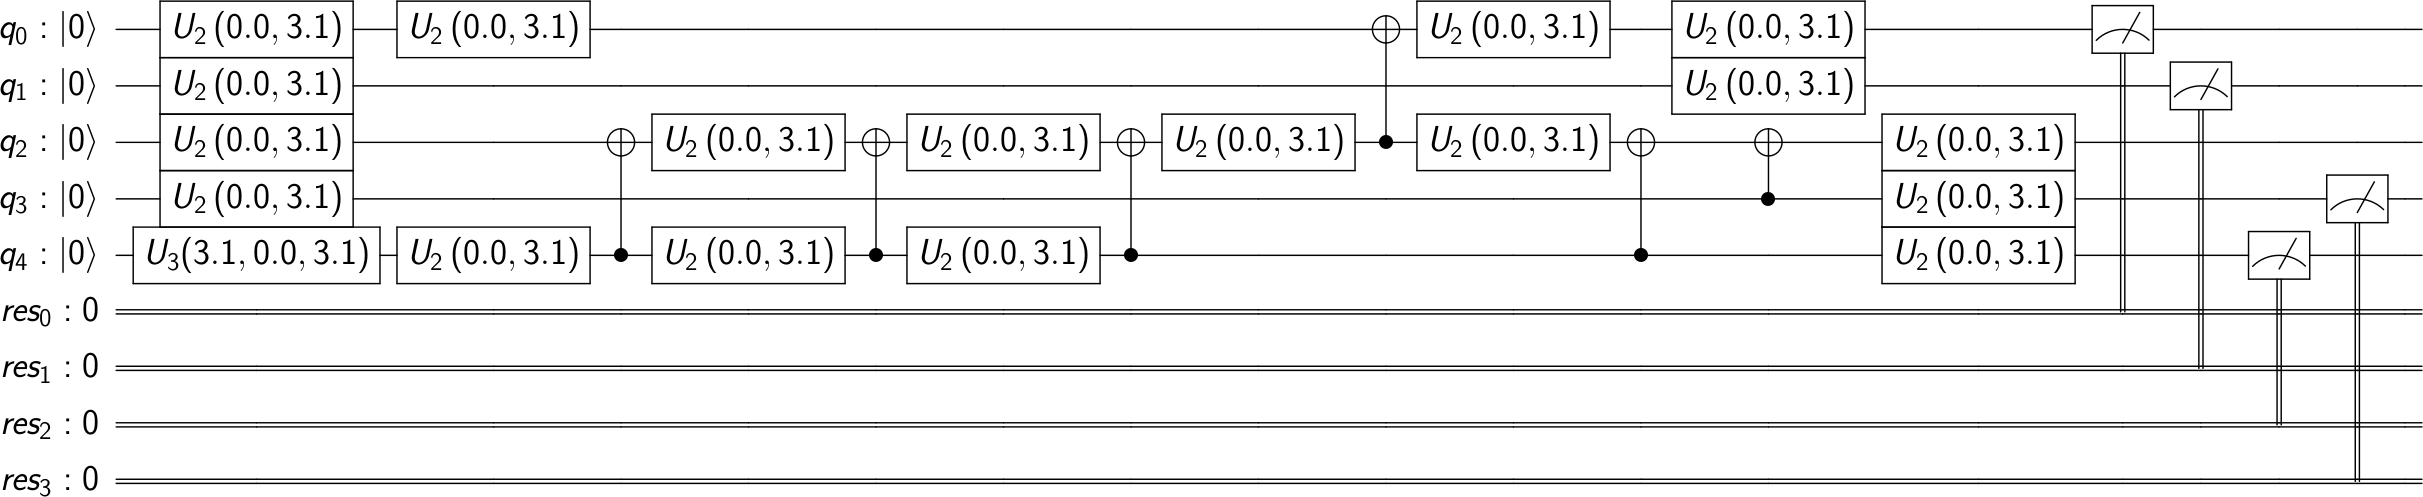

In [22]:
# what does the compiled circuit look like for the above result?
from qiskit.transpiler import transpile, PassManager
transpiled_bv = transpile(bv, device, seed_mapper=3, pass_manager=None)
print(transpiled_bv.count_ops())
transpiled_bv.draw(output='latex', plot_barriers=False)

{'u3': 1, 'barrier': 4, 'u2': 22, 'cx': 6, 'measure': 4}


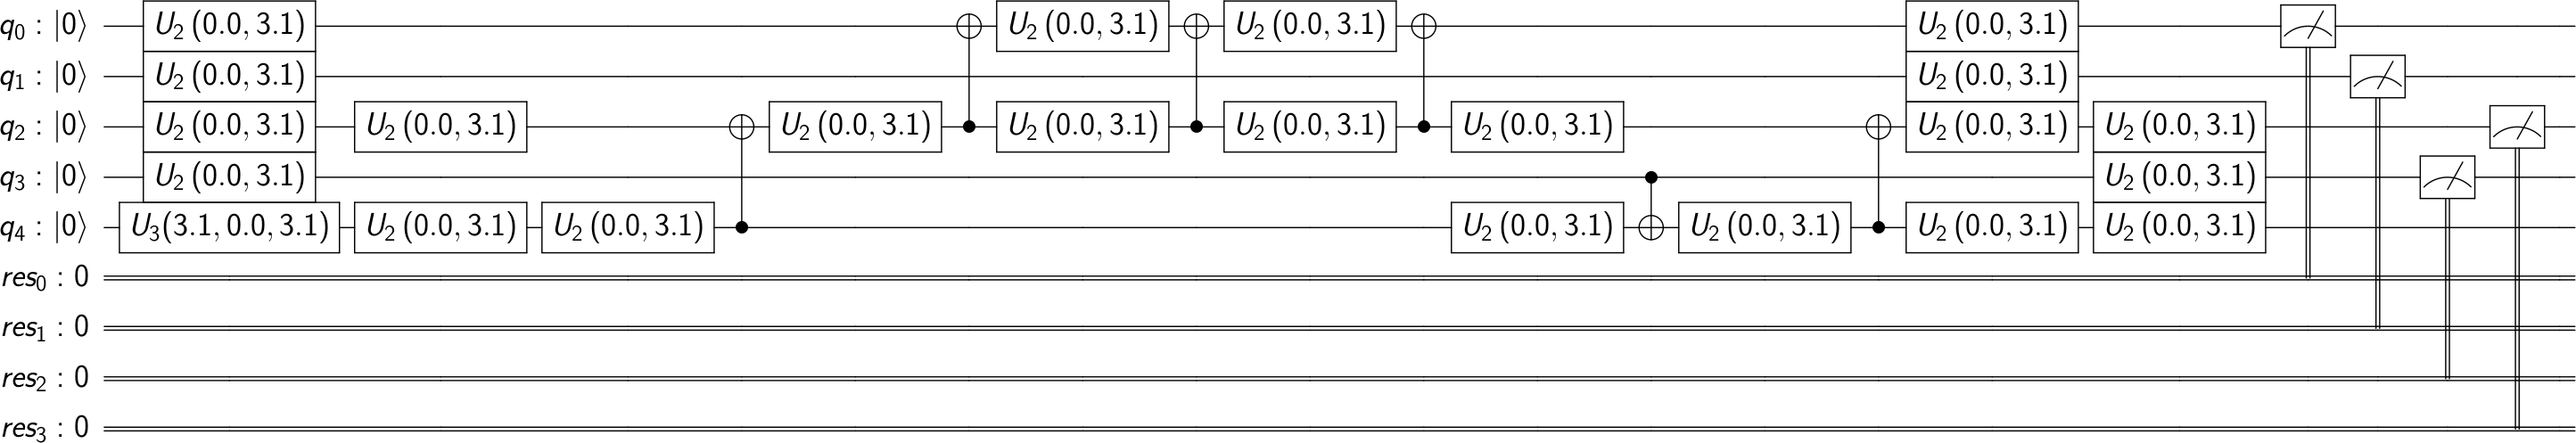

In [23]:
# choose a different layout for the qubits
initial_layout = Layout([q[3], q[1], q[0], q[2], tmp[0]])
transpiled_bv_1 = transpile(bv, device, initial_layout=initial_layout, seed_mapper=2, pass_manager=None)
print(transpiled_bv_1.count_ops())
transpiled_bv_1.draw(output='latex', plot_barriers=False)

{'u3': 1, 'barrier': 4, 'u2': 22, 'cx': 6, 'measure': 4}


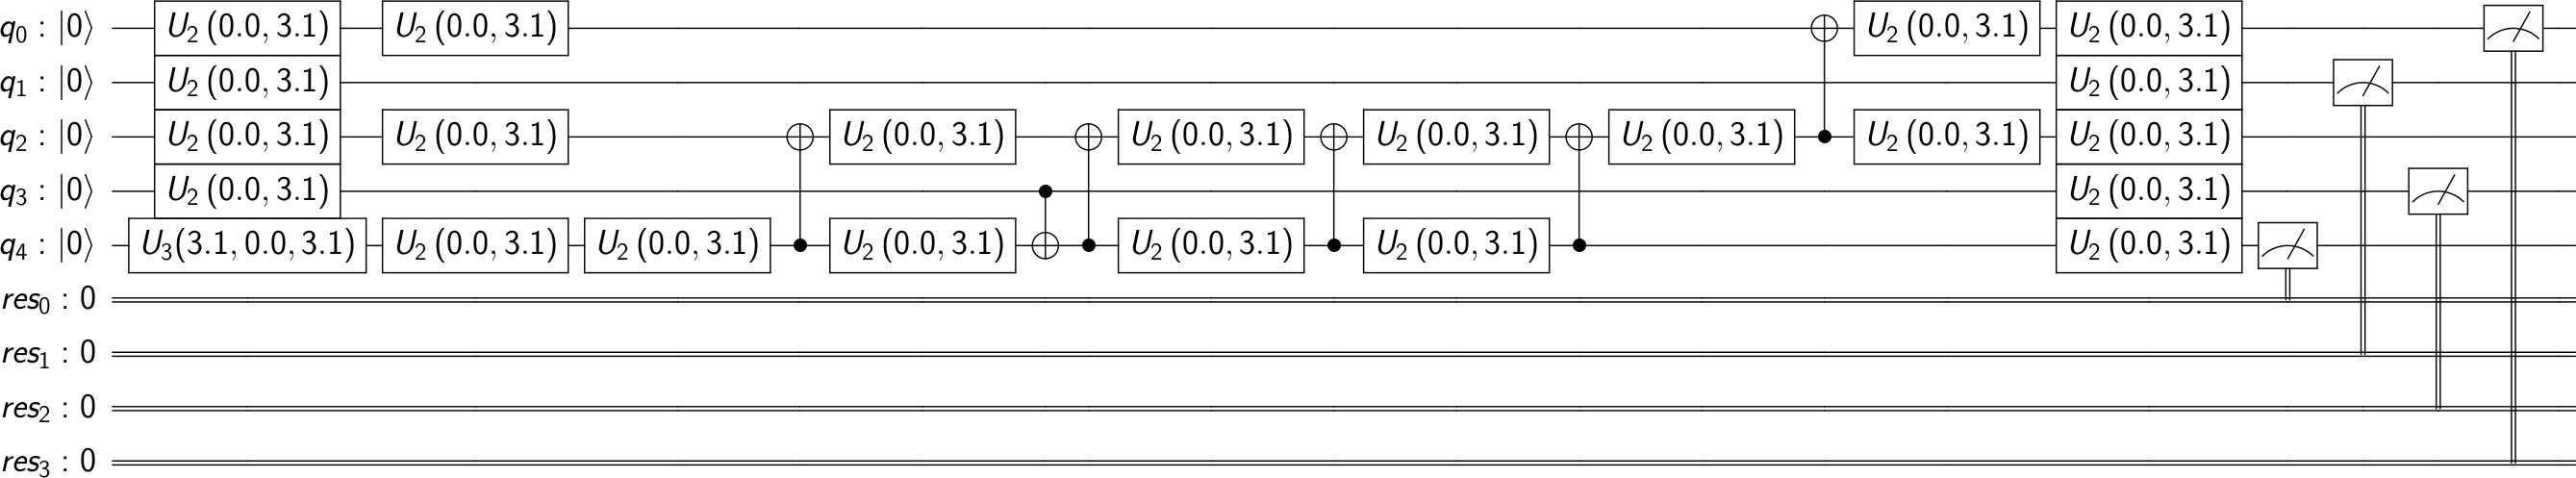

In [24]:
# customize the transpiler pipeline
from qiskit.transpiler.passes import *
from qiskit.transpiler import PassManager
from qiskit.extensions.standard import SwapGate

pm = PassManager()
pm.append(LookaheadSwap(coupling_map, initial_layout=initial_layout))
pm.append(Decompose(SwapGate))
#pm.append(GreedyTemplates())
pm.append(CXCancellation())
pm.append(Optimize1qGates())
pm.append(CXDirection(coupling_map))
pm.append(Unroller(basis))
pm.append(Optimize1qGates())

transpiled_bv_2 = transpile(bv, device, pass_manager=pm)

print(transpiled_bv_2.count_ops())
transpiled_bv_2.draw(output='latex', plot_barriers=False)

In [25]:
from qiskit.compiler import *
qobj = assemble_circuits([transpiled_bv, transpiled_bv_1, transpiled_bv_2], RunConfig(shots=1000))

In [26]:
%%qiskit_job_status

# run the latter circuit. 
# compare with the original run to see effect of compilation on result fidelity.
job = device.run(qobj)

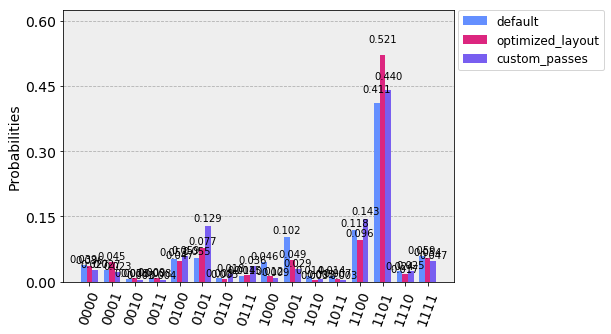

In [27]:
device_counts = job.result().get_counts(0)
device_counts_1 = job.result().get_counts(1)
device_counts_2 = job.result().get_counts(2)
plot_histogram([device_counts, device_counts_1, device_counts_2],
               legend=['default', 'optimized_layout', 'custom_passes'])

How to choose the best layout?

In [28]:
%qiskit_backend_monitor device

/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqbackend.py:188: DeprecationWarning: Some jobs are in a no-longer supported format. Please send the job using Qiskit 0.8+. Old jobs:
 - 5c1569e0d463c70054fb1753
  '\n - {}'.format(job_ids), DeprecationWarning)


### 5. Mitigate Readout Errors

In [29]:
# Import measurement calibration functions from Qiskit Ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter, MeasurementFilter

In [39]:
# Generate the calibration circuits
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0, 1, 3, 2], circlabel='mcal')

In [40]:
%%qiskit_job_status

# Execute the calibration circuits
job = execute(meas_calibs, device, shots=1000)

In [41]:
# Calculate the calibration matrix with the noise model
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

import numpy
numpy.set_printoptions(threshold=200)
print(meas_fitter.cal_matrix)

[[0.916 0.112 0.134 ... 0.    0.    0.001]
 [0.02  0.842 0.003 ... 0.001 0.    0.   ]
 [0.021 0.005 0.793 ... 0.    0.005 0.   ]
 ...
 [0.    0.013 0.    ... 0.761 0.002 0.116]
 [0.    0.    0.004 ... 0.003 0.739 0.074]
 [0.    0.    0.    ... 0.016 0.01  0.687]]


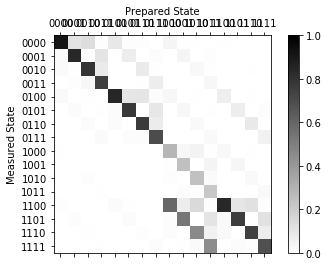

In [42]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [43]:
# Results without mitigation
qobj = assemble_circuits(transpiled_bv_1, RunConfig(shots=1000))
raw_result = device.run(qobj).result()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_result = meas_filter.apply(raw_result)

In [44]:
raw_counts_1 = raw_result.get_counts()
mitigated_counts_1 = mitigated_result.get_counts()

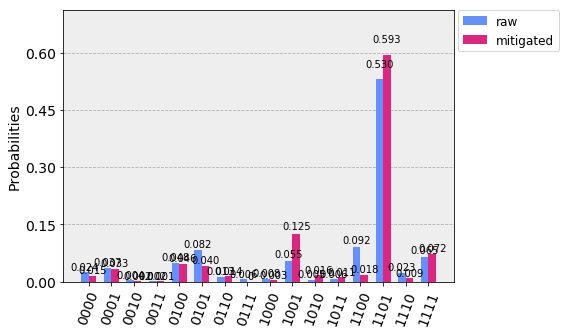

In [45]:
plot_histogram([raw_counts_1, mitigated_counts_1], legend=['raw', 'mitigated'])